In [1]:
from network.examples import community, virus
from network.simulation import rv, test, run_simulations, create_runner
from network.randoms import fix_random
from network.graph import Graph

import random

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters of simulation

To start, we construct a graph based on the idea of "communities", that is, sub-groups within the graph whose members have close connections with one another. These simulate the existence of families, households, and roommates. I call these **core connections**. 

Outside of core connections exist **strong connections**, those between people of different households but still have significant interaction/time spent together. Examples of these include coworkers and friends hanging out together.

Finally, we have we **weak connections**, where people of different households engage in casual, limited contact. These include people you only briefly interact with at work, a casual conversation with a stranger, or service workers engaging with customers.

**Graph parameters**

* `n_communities` = number of communities/households
* `community_size` = household size
* `orphans` = number of single people with only outside connections
* `total_people` = total # of people in simulation, calculated by adding people in households to number of "orphans"
* `n_strong_conns` = total # of strong connections in the graph. I generally put it as some multiple of people in the simulation - for example, if each person had 3 strong connections outside their household, this would be `3 * total_people`.
* `n_weak_conns` = total # of weak connections in the graph. Similar idea as `n_strong_conns`.

**Strength parameters**

Each category of connections has an average _strength_, a measure of the likelihood of transmission across those edges. Not surprisingly, core connections would have the highest strength, followed by strong and then weak connections, based on time and closeness spent together in a closed space. These are set in `core_strength`, `strong_strength`, and `weak_strength`.

Regarding strong connections, we assume they are persistent - the people you interact closely with outside your household generally stays the same through a given period of time. For example, the coworkers and friends you interact with today, you'll likely interact with tomorrow as well. The same cannot be said for a customer at a restaurant who acts as a weak interaction for a waiter.

* `p_strong_interact` = probability on any given day any given strong interaction will recur.

With those parameters set, we can generate a base or template graph which we will use in our simulations, stored in the variable `graph0`.

In [37]:
n_communities = 800
community_size = 3
orphans = 800
total_ppl = n_communities * community_size + orphans

n_strong_conns = total_ppl * 3
n_weak_conns = total_ppl * 6

core_strength = 0.6
strong_strength = 0.4
p_strong_interact = 4 / 7
weak_strength = 0.1

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw={'strength': core_strength}, 
        strong_kw={'strength': strong_strength}, 
        weak_kw={'strength': weak_strength}
    )
    return graph

with fix_random():
    graph0 = generate_graph()

## Business as usual

In a "business-as-usual", no mitigation scenario, the following occurs each day:
* Core connections remain as-is with no change
* You might encounter a strong connection by hanging out with a friend or working with someone at work. If not, we disable that strong connection by setting its strength to zero.
* All weak edges are reset as you will encounter new strangers on each day.

In [38]:
def reset_non_core_edges(transmission):
    graph = transmission.graph
    weak_edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in weak_edges_to_remove:
        graph.remove_edge(prev_weak_edge)
        
    strong_edges = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'strong']

    n_new_weak_edges = len(weak_edges_to_remove)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=weak_strength)
        
    for edge in strong_edges:
        new_strength = strong_strength if test(p_strong_interact) else 0
        graph.update_edge(edge, strength=new_strength)
        
no_mitigation = create_runner(before=reset_non_core_edges)

## Mitigation measures

**Quarantine**: 75% of strong and weak connections are removed. The remaining exist due to the presence of interactions stemming from essential workers.

**Masking**: These reduce transmission probabilities to an amount specified in `mask_factors` parameter. By default, it is assumed masks would reduce transmission to 15% of original for weak interactions (figure taken from this Lancet paper: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)31142-9/fulltext), and 50% of original for strong interactions, assuming masks are less effective for elongated, close interaction. We assume behaviors and hence transmission probabilities are not altered for core connections.

**Both**: Quarantines and mask mandates are both enacted.

In [39]:
def enact_quarantine(transmission):
    graph = transmission.graph
    
    def should_remove_edge(edge):
        if edge.attr('kind') == 'strong' and test(0.75):
            return True
        if edge.attr('kind') == 'weak' and test(0.75):
            return True
        return False
    
    if not transmission.props.get('in_quarantine', False):
        transmission.props['in_quarantine'] = True
        edges_to_remove = [e for e in graph.iter_edges() if should_remove_edge(e)]
        for edge in edges_to_remove:
            graph.remove_edge(edge.nodes)
        
        
def put_on_masks(transmission, mask_factors=None, perc_masks=1.0):
    graph = transmission.graph
    if mask_factors is None:
        mask_factors = {
            'core': 1.0,
            'strong': 0.5,
            'weak': 0.15
        }
    for edge in graph.iter_edges():
        if test(perc_masks):
            graph.update_edge(edge.nodes, strength=mask_factors[edge.attr('kind')] * edge.attr('strength'))
                
                
def quarantine_and_mask(transmission):
    put_on_masks(transmission)
    enact_quarantine(transmission)
        
        
def runner_do_at(day, func):
    def before_func(transmission):
        reset_non_core_edges(transmission)
        if transmission.steps >= day:
            func(transmission)
    
    return create_runner(before=before_func)

## Run the simulation

**Run parameters**
* `action_day` is the day we turn on the aforementioned mitigation measures. 
* `run_to` is how many days we run the simulation
* `incubation_period` is that of the virus (in days) before the infected person becomes contagious
* `contagious_for` is how many days the infected person remains out-and-about before completely self-isolating and no longer transmitting to others

Default values of 2-14 days for incubation period from https://www.cdc.gov/coronavirus/2019-ncov/hcp/faq.html#Transmission

Note the usage of the `simulation.rv` module to set a parameter as a random variable.

In [54]:
action_day = 24
run_to = 80
incubation_period = rv.randint(2, 14)
contagious_for = rv.choice(0, 1, 2)

In [55]:
def generate_sim(graph, runner):
    with fix_random():
        return virus.virus_simulation(
            graph=Graph.duplicate(graph),
            patient0=1,
            incubation_period=incubation_period,
            contagious_for=contagious_for,
            runner=runner
        )

In [47]:
sim_control = generate_sim(graph0, runner=no_mitigation)
sim_quarantine = generate_sim(graph0, runner=runner_do_at(action_day, enact_quarantine))
sim_masks = generate_sim(graph0, runner=runner_do_at(action_day, put_on_masks))
sim_both = generate_sim(graph0, runner=runner_do_at(action_day, quarantine_and_mask))

In [48]:
results = run_simulations(
    sim_control,
    sim_quarantine,
    sim_masks,
    sim_both,
    to=run_to
)

## Plot results

Text(0, 0.5, 'Cases')

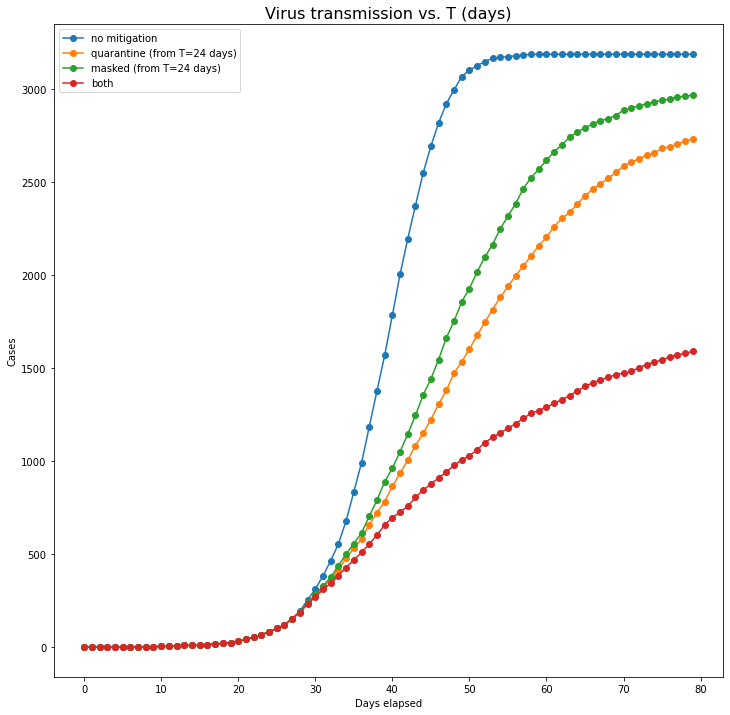

In [52]:
def sim_sequence(sim, n):
    for i in range(n):
        index = -1 if i >= len(sim.history) else i
        yield sim.history[index].broadcasts

fig = plt.figure(figsize=(12, 12))
plt.title('Virus transmission vs. T (days)', fontsize=16)
lines = []
for sim in results:
    line, = plt.plot(range(80), list(sim_sequence(sim, 80)), 'o-')
    lines.append(line)

plt.legend(
    lines, 
    ['no mitigation', f'quarantine (from T={action_day} days)', f'masked (from T={action_day} days)', 'both'], 
    loc='upper left'
)
plt.xlabel('Days elapsed')
plt.ylabel('Cases')